# Schelling

In 1971, the American economist Thomas Schelling developed an agent-based model that may help explain why segregation is so difficult to eradicate. His segregation model demonstrated that even when individuals would not mind living among individuals of a different race, they would gradually isolate themselves from other agents over time (https://en.wikipedia.org/wiki/Schelling%27s_model_of_segregation).

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
from random import randint, choice
import networkx as nx
import collections

plt.style.use('seaborn-whitegrid')
matplotlib.rcParams.update({'errorbar.capsize': 3})

### Useful functions

In [2]:
def draw_network(G):  
    fig = plt.figure(figsize=(8,6))
    pos = nx.circular_layout(G)  # positions for all nodes, circular layout was chosen because it seems easier to visualize
    node_color = []
    for race in list(nx.get_node_attributes(G, 'race').values()):
        if race == 'W':
            node_color.append('red')
        else:
            node_color.append('green')
    nx.draw(G, pos = pos, with_labels=True, node_color=node_color)
    red_patch = mpatches.Patch(color='red', label='White')
    green_patch = mpatches.Patch(color='green', label='Black')
    plt.legend(handles=[red_patch,green_patch])    
    plt.show()

In [3]:
def compute_happiness(G,i):
    m = 0 #number of neighbors with same race
    tot_neighbors = int(G.degree()[i]) # degree of node i
    #print(tot_neighbors)     
    #print(list(G.edges(i)))
    edge_list = list(G.edges(i))
    race_i = G.nodes[i]['race']
    #print(("Race of node n.%s is: %s")%(i,race_i))

    for j in range(tot_neighbors):
        nodo = int(edge_list[j][1])
        #print(nodo)
        #print(nx.get_node_attributes(G, "race"))
        race_j = nx.get_node_attributes(G, "race")[nodo]
        if race_j == race_i:
            m += 1
            
    #print(("The fraction of first neighbors with same race is: %s")%(np.round(m/tot_neighbors,2)))
    if tot_neighbors != 0:
        G.nodes[i]['happiness'] = np.round(m/tot_neighbors,5) 
    else:
        sys.exit('Some nodes have 0 edges, the code cannot run. Run again, increase probability of edge formation p and/or number of nodes n')

## Model

Schelling initial state of the model should reflect a society which is not segregated. We choose a Erdős–Rényi random graph (https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) to start with and we assign a $\textit{race}$ to each node with a 50\% probability.

Then, we introduce the vector $s = (s_{1}, . . . , s_{N} )$, where the entry $s_{i}$ is a real number between 0 and 1, encoding the satisfaction of the $i^{th}$ agent.

After that, we can start to see how $\textit{Tolerance}$ affects agents segregation, we can choose a $\textit{level of Tolerance}$, defined as "the desidered fraction of first neighbors with same race as the agent taken into consideration". It can vary between 0 and 1 (extremes are not included). Values closer to 0, will have little to no segregation effect, while values closer to 1 will have the opposite effect.

In [4]:
def Schelling_model(n,p, graph = True, seed = 769231):
    #seed can be if we want the random numbers to be predictable, but not if we do many runs as done below
    #np.random.seed(seed) 
    
    G = nx.erdos_renyi_graph(n, p)#,seed)
    # half nodes are B and half are W. They could have been assigned randomly but this way is easier to visualize
    # and it's about the same
    for i in range(n):
        if i <int(n/2):
            G.nodes[i]['race'] = 'B'
        else:
            G.nodes[i]['race'] = 'W'
    
    #compute happiness for each node, using the compute_happiness function defined previously
    tot_happy = 0
    for i in range(n):
        compute_happiness(G,i)
        tot_happy += G.nodes[i]['happiness']
        
    #plot initial network
    if graph == True:
        print(('##### Starting network: Erdos-Renyi G(%s,%s) #####')%(n,p))
        draw_network(G)
        print(("Total segregation: %.2f")%(tot_happy/n))

    #iterating over different values of tolerance
    tol_array = np.arange(0.1,0.9,0.1)
    happiness = []
    print('\t  .....iterating over many values of tolerance..... ')
    for tol in tol_array:
        G1 = G.copy()
        tot_happy = 0
        for i in range(n):
            #agents that are not happy enough can move if they find some place better
            while (G1.nodes[i]['happiness'] < tol):
                #old_happ = G1.nodes[i]['happiness'] 
                i_edges_list = list(G1.edges(i))
                #print(i_edges_list)
                len_list = len(i_edges_list)
                #print("prima", len_list)
                G1.remove_edges_from(i_edges_list)
                pool = np.arange(n)
                pool = np.delete(pool, np.where(pool==i)) #pool from where we randomly choose node to connect with, does not include the main node
                #print(pool)
                edges = np.array(np.random.choice(pool,len_list,replace=False))
                #print(edges)
                new_edges_list = []
                for j in range(len_list):
                    new_edges_list.append(tuple([i,edges[j]]))
                #print(new_edges_list)        
                G1.add_edges_from(new_edges_list)
                compute_happiness(G1,i)
                #if G1.nodes[i]['happiness'] < old_happ:
                #    G1.remove_edges_from(new_edges_list)
                #    G1.add_edges_from(i_edges_list)
                #    compute_happiness(G1,i)
                #print("dopo",len(new_edges_list))
                #print("edges: %s"%(G.edges(i)))
            tot_happy += G1.nodes[i]['happiness']
        if graph == True:
            draw_network(G1)
            print(("With a value of tolerance: %.2f out of 1, we have total segregation: %.2f out of 1")%(tol,tot_happy/n))
        happiness.append(tot_happy/n)
        
    return happiness, tol_array

RUN 1
##### Starting network: Erdos-Renyi G(50,0.2) #####


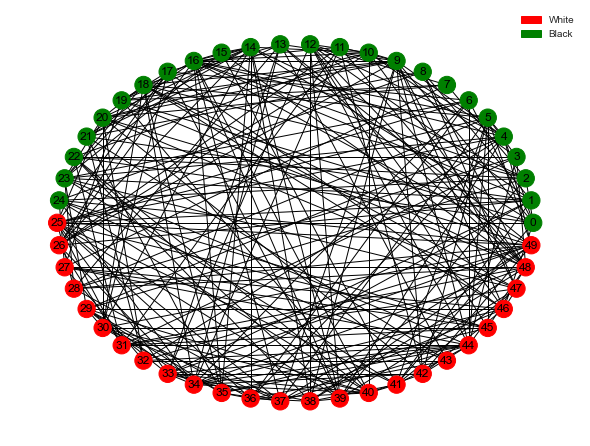

Total segregation: 0.55
	  .....iterating over many values of tolerance..... 


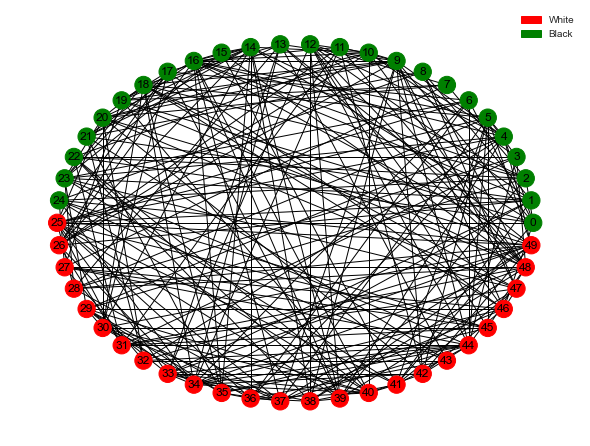

With a value of tolerance: 0.10 out of 1, we have total segregation: 0.55 out of 1


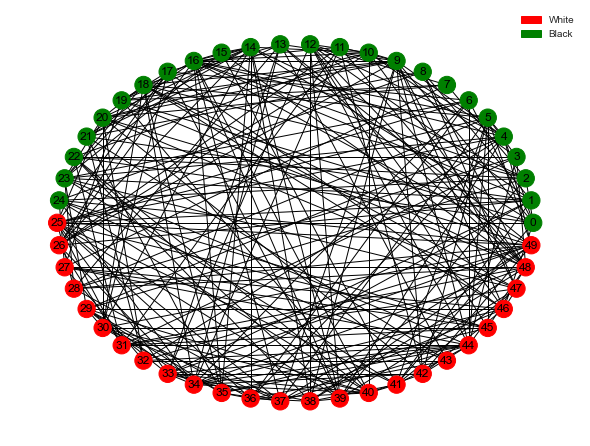

With a value of tolerance: 0.20 out of 1, we have total segregation: 0.55 out of 1


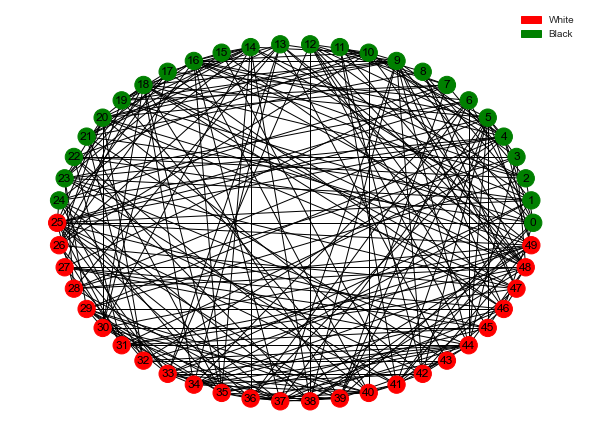

With a value of tolerance: 0.30 out of 1, we have total segregation: 0.56 out of 1


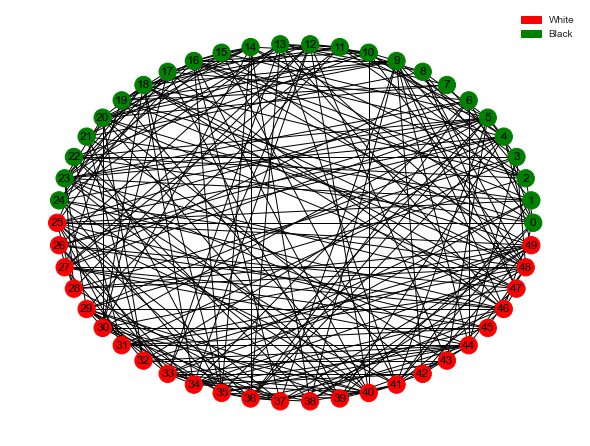

With a value of tolerance: 0.40 out of 1, we have total segregation: 0.58 out of 1


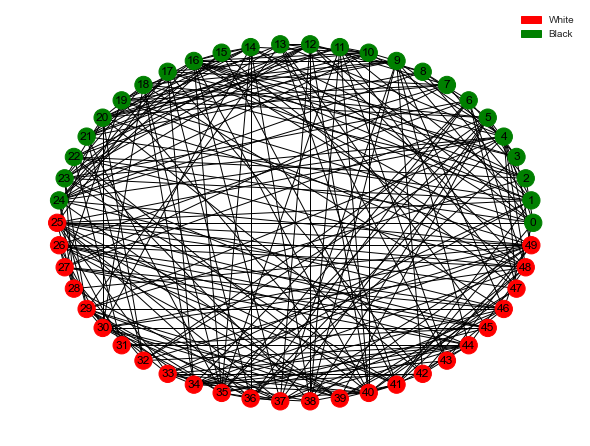

With a value of tolerance: 0.50 out of 1, we have total segregation: 0.61 out of 1


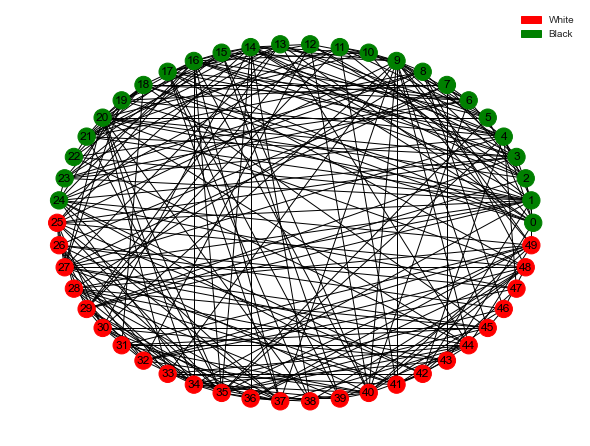

With a value of tolerance: 0.60 out of 1, we have total segregation: 0.68 out of 1


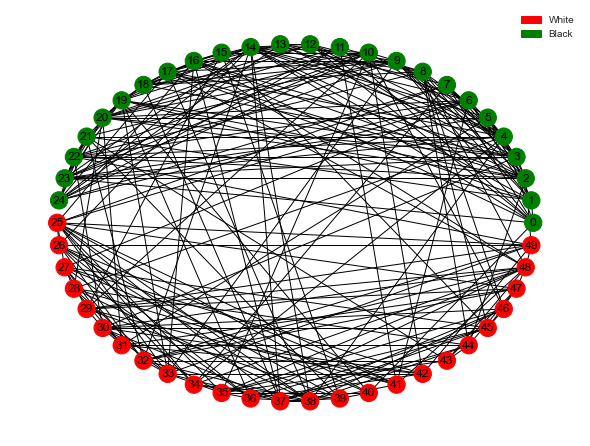

With a value of tolerance: 0.70 out of 1, we have total segregation: 0.78 out of 1


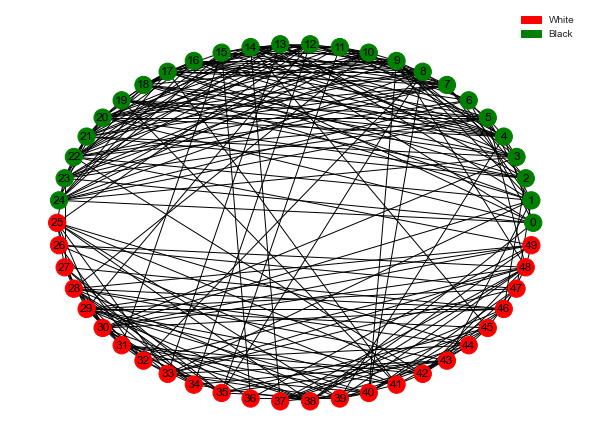

With a value of tolerance: 0.80 out of 1, we have total segregation: 0.85 out of 1

RUN 2
	  .....iterating over many values of tolerance..... 
RUN 3
	  .....iterating over many values of tolerance..... 
RUN 4
	  .....iterating over many values of tolerance..... 
RUN 5
	  .....iterating over many values of tolerance..... 
RUN 6
	  .....iterating over many values of tolerance..... 
RUN 7
	  .....iterating over many values of tolerance..... 
RUN 8
	  .....iterating over many values of tolerance..... 
RUN 9
	  .....iterating over many values of tolerance..... 
RUN 10
	  .....iterating over many values of tolerance..... 


In [5]:
#we can do many runs (10 for example) so that we can plot a graph with an estimated error

trials = np.zeros((10,8))
n = 50 #number of agents
p = 0.2 #probability for edge creation

print('RUN 1')
trials[0],tol_array = Schelling_model(n,p);
# it works well with this value of p, while values of n could be changed to see how the Schelling model behaves 
# with many more agents, the problem is that it is quite slow when increasing n and it is difficult to visualize, 
# so it's better to add graph = False

print('')
for i in range(len(tol_array)+1):
    print(('RUN %s')%(i+2))
    trials[i+1], tol_array = Schelling_model(n,p, graph = False);

In [6]:
happiness = trials.sum(axis = 0)/10
semi_dispersion = (trials.max(axis = 0) - trials.min(axis = 0))/2

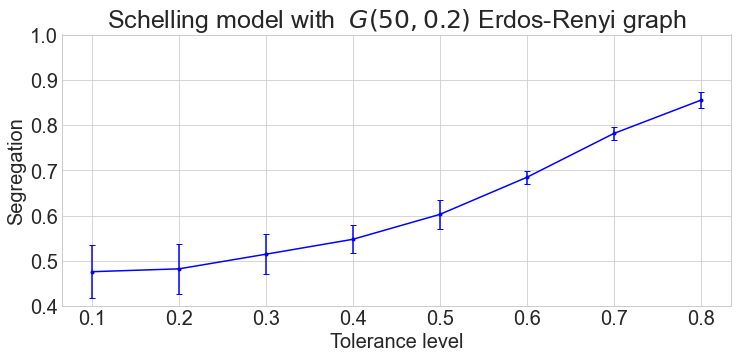

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.title(r'Schelling model with  $G(%s,%s)$ Erdos-Renyi graph'%(n,p), fontsize = 25)
plt.errorbar(tol_array, happiness, yerr = semi_dispersion, linestyle = "-", fmt='.b');
plt.xlabel('Tolerance level', fontsize =20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Segregation', fontsize = 20)
plt.ylim(0.4, 1)

plt.show()